# Bitcoin Price Prediction Project

This notebook contains sections as below:

1. Abstract
2. Data description
3. Gathering data
4. Data preprocessing
5. ARIMA Model
   - 5.1. ARIMA Model  =>  complete data + ln(data)
   - 5.2. ARIMA Model  =>  complete data + without ln(data)
   - 5.3. ARIMA Model  =>  data start from 2018-01-01 + ln(data)
   - 5.4. ARIMA Model  =>  data start from 2021-01-01 + ln(data)
   - 5.5. ARIMA Model  =>  summary

## 1. Abstract

Bitcoin is a cryptocurrency, created in 2009. Bitcoin system is a set of decentralized nodes with the bitcoin code that contains collection of transactions. A blockchain is a distributed database that is shared among the nodes of a computer network. As a database, a blockchain stores information in digital format. All the computers running the blockchain has the same list of blocks and transactions and can see all these new blocks being filled with new bitcoin transactions.

The original purpose of Bitcoin (BTC in short) is to allow two people to exchange value directly (using peer-to-peer technology), without centralbanks or goverments, regardless where they are. What this means is that Bitcoin blockchain is decentralized -  there is no centralized controll on this network.

Responsibility for processing transactions on the blockchain is done by - so called - Miners. "Mining" is performed using sophisticated hardware that solves an extremely complex math problem. The first computer to find the solution to the problem receives the next block of bitcoins and the process begins again. A newly mined block of bitcoins now can be used to store a value or be sold.

The amount of bitcoins is predetermined. Each and every Bitcoin had to be mined previously. For every four years the amount of bitcoins that can be mined, decreeses by half. That is so called halving of Bitcoin. The next halving will be in 2024 and means that miners will receive half of current revard for processing transactions.

Decentralization, predetermined amount and current dificulty of gaining new Bitcoins by miners is the reason why Bitcoin is so popular. Some people even calls it a digital gold. Popularity of Bitcoin makes the bitcoin market very volatile that is much higher compared to traditional currencies. Volatile marcet, may be an opportunity for speculation and other advantages of bitcoin may lead to long term, store of value strategy.

Popilarity of bitcoin has led invest founds to gain digitall assets in their wallets. This may disturb Bitcoin four years halving cycles.

Predicting Bitcoin price based on historical data should be accounted for, by the prism of marcet sentiment, current bitcoin phase and movement of large capital from invest founds and currend big holders.

## 2. Data description

Historical data price has been taken from Coinpaprika API Python Client.
- Web Site - https://coinpaprika.com/waluta/btc-bitcoin/
- Github   - https://github.com/s0h3ck/coinpaprika-api-python-client

Coinpaprika is a popular data source for various cryptocurrencies, with Polish origins based in city of Poznań.
Free Coinpaprika API provides data in JSON and has limitation for amount of data per request. For example maximum of 50 tweets or historical data for at most 365 days at one request.
Examples of use can be found in their Github site.

To gain the access it is necessary to instal coinpaprica package:

In [1]:
# pip install coinpaprika

And import a data client from the installed pacage.

In [2]:
from coinpaprika import client as Coinpaprika

The rest used in this notebook packages:

In [3]:
import pandas as pd
import numpy as np

from datetime import datetime, date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

# kto wie
from math import sqrt

Load the Coinpaprica client and get random data sample.

In [4]:
client = Coinpaprika.Client()

## 3. Gathering data

In [5]:
# Get historical OHLCV information for a specific coin (USD,BTC)

client.candles("btc-bitcoin", quotes="USD", start="2014-01-11T00:00:00Z")

[{'time_open': '2014-01-11T00:00:00Z',
  'time_close': '2014-01-11T23:59:59Z',
  'open': 867.32,
  'high': 921.48,
  'low': 861.72,
  'close': 913.95,
  'volume': 44754200,
  'market_cap': 11195636163}]

Limitation of historical data per request is 365 days. That is why it is necesarry to collect the data from Coinpaprica in parts and gather those parts in one dataset.

In [6]:
# client.candles("btc-bitcoin", quotes="USD", start="2020-01-01T00:00:00Z", end="2020-12-31T00:00:00Z")

Above request will be missing of one day (2020-12-31) and will end in 365 day of the year (2020-12-30). This is the reason to split one year reguest of data into two requests.

In [7]:
btc_array = []
days = 0

for year in range(2009, 2022+1, 1):
    
    first_half_start = str(year) + "-01-01T00:00:00Z"
    first_half_end = str(year) + "-06-30T00:00:00Z"
    second_half_start = str(year) + "-07-01T00:00:00Z"
    second_half_end = str(year) + "-12-31T00:00:00Z"
    
    first_half = client.candles("btc-bitcoin", quotes="USD", start=first_half_start, end=first_half_end)
    second_half = client.candles("btc-bitcoin", quotes="USD", start=second_half_start, end=second_half_end)
    
    btc_array = btc_array + first_half + second_half
    days_year = len(first_half + second_half)
    days = days + days_year
    print("Year:",year, "; Number of days in count:", days_year)

print("Days in total:", days)

Year: 2009 ; Number of days in count: 0
Year: 2010 ; Number of days in count: 168
Year: 2011 ; Number of days in count: 365
Year: 2012 ; Number of days in count: 366
Year: 2013 ; Number of days in count: 365
Year: 2014 ; Number of days in count: 365
Year: 2015 ; Number of days in count: 365
Year: 2016 ; Number of days in count: 366
Year: 2017 ; Number of days in count: 365
Year: 2018 ; Number of days in count: 365
Year: 2019 ; Number of days in count: 365
Year: 2020 ; Number of days in count: 366
Year: 2021 ; Number of days in count: 365
Year: 2022 ; Number of days in count: 72
Days in total: 4258


As it is shown above, Coinpaprika has no historical data from 2009 year and incomplite data from year 2010.

Check the length of gathered data.

In [8]:
len(btc_array)

4258

Check the last request.

In [9]:
btc_array[-1]

{'time_open': '2022-03-13T00:00:00Z',
 'time_close': '2022-03-13T15:40:00Z',
 'open': 38946.51093209971,
 'high': 39234.46600125336,
 'low': 38577.97941715809,
 'close': 38967.97666778648,
 'volume': 18573900968,
 'market_cap': 739702563892}

Convert gathered data to Pandas Data Frame and set the indexes starting from 1.

In [10]:
btc_df_gathered = pd.DataFrame(btc_array, index=(x for x in range(1, len(btc_array) + 1)))

Display df head with 100 rows.

In [11]:
btc_df_gathered.head(100)

,time_open,time_close,open,high,low,close,market_cap,volume
1,2010-07-17T00:00:00Z,2010-07-17T23:59:59Z,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2,2010-07-18T00:00:00Z,2010-07-18T23:59:59Z,0.04951,0.04951,0.04951,0.04951,NaN,NaN
3,2010-07-19T00:00:00Z,2010-07-19T23:59:59Z,0.08584,0.08584,0.08584,0.08584,NaN,NaN
4,2010-07-20T00:00:00Z,2010-07-20T23:59:59Z,0.08080,0.08080,0.08080,0.08080,NaN,NaN
5,2010-07-21T00:00:00Z,2010-07-21T23:59:59Z,0.07474,0.07474,0.07474,0.07474,NaN,NaN
...,...,...,...,...,...,...,...,...
96,2010-10-20T00:00:00Z,2010-10-20T23:59:59Z,0.09700,0.09700,0.09700,0.09700,NaN,NaN
97,2010-10-21T00:00:00Z,2010-10-21T23:59:59Z,0.09900,0.09900,0.09900,0.09900,NaN,NaN
98,2010-10-22T00:00:00Z,2010-10-22T23:59:59Z,0.10700,0.10700,0.10700,0.10700,NaN,NaN
99,2010-10-23T00:00:00Z,2010-10-23T23:59:59Z,0.10250,0.10250,0.10250,0.10250,NaN,NaN


Display tail of the df.

In [12]:
btc_df_gathered.tail()

,time_open,time_close,open,high,low,close,market_cap,volume
4254,2022-03-09T00:00:00Z,2022-03-09T23:59:59Z,38725.211796,42477.180071,38708.018503,42001.198148,7.971370e+11,4.050145e+10
4255,2022-03-10T00:00:00Z,2022-03-10T23:59:59Z,41987.574998,42065.637224,38835.877216,39476.636167,7.492591e+11,3.893727e+10
4256,2022-03-11T00:00:00Z,2022-03-11T23:59:59Z,39443.197138,40139.740182,38346.593364,38895.209106,7.382566e+11,3.100819e+10
4257,2022-03-12T00:00:00Z,2022-03-12T23:59:59Z,38869.052186,39338.967238,38813.927397,38993.560483,7.401621e+11,1.639725e+10
4258,2022-03-13T00:00:00Z,2022-03-13T15:40:00Z,38946.510932,39234.466001,38577.979417,38967.976668,7.397026e+11,1.857390e+10


Save gathered data in to .csv file as a backup.

In [13]:
btc_df_gathered.to_csv("BTC_Preprocess_Backup.csv", sep = ",", index = True)

## 4. Data preprocessing

For price prediction it will be used columns "close" and "time_close" as idex. 
Current df has to be refactored.

In [14]:
# copy data to new df
btc_df_1 = btc_df_gathered

In [15]:
# check datatypes
btc_df_1.dtypes

time_open      object
time_close     object
open          float64
high          float64
low           float64
close         float64
market_cap    float64
volume        float64
dtype: object

In [16]:
# change df index to date
btc_df_1.index = pd.to_datetime(btc_df_1["time_close"]).dt.date
# drop "time_open", "time_close" columns
btc_df_1.drop(["time_open", "time_close"], axis=1, inplace=True)
btc_df_1.head()

,open,high,low,close,market_cap,volume
time_close,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2010-07-18,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2010-07-19,0.08584,0.08584,0.08584,0.08584,NaN,NaN
2010-07-20,0.08080,0.08080,0.08080,0.08080,NaN,NaN
2010-07-21,0.07474,0.07474,0.07474,0.07474,NaN,NaN


In [17]:
# show df shape
btc_df_1.shape

(4258, 6)

In [18]:
btc_df_1.describe()

,open,high,low,close,market_cap,volume
count,4258.000000,4258.000000,4258.000000,4258.000000,3.242000e+03,2.999000e+03
mean,7471.664387,7666.627485,7262.907556,7481.158074,1.800121e+11,1.194565e+10
std,14130.603451,14493.317633,13735.360919,14139.827965,2.916433e+11,1.708183e+10
min,0.049510,0.049510,0.049510,0.049510,7.784112e+08,2.857830e+06
25%,109.513750,113.294750,106.663500,109.132500,6.492863e+09,5.533155e+07
50%,633.282000,646.895000,621.676000,633.366500,6.404985e+10,3.646006e+09
75%,8118.593842,8266.874413,7888.309430,8129.363704,1.735474e+11,1.859144e+10
max,67589.872823,68692.137037,66457.970074,67589.768671,1.275266e+12,1.363702e+11


## 5. ARIMA Model

For the Autoregressive Integrated Moving Average (ARIMA) Model data should be stationary.
ARIMA Model is popular for predicting linear time series data.
- AR stands for autoregressive (p)
- I stand for Integrated (d), 
- MA stands for moving average (q)

Auto ARIMA - automatically discover the optimal order (p, d, q) for an ARIMA model.

For evaluating model performance the Root Mean Square Error (RMSE) will be used - should be as low as possible.

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

### 5.1. ARIMA Model  =>  complete data + ln(data)

In [20]:
# copy full dataset
df_close = btc_df_1['close']

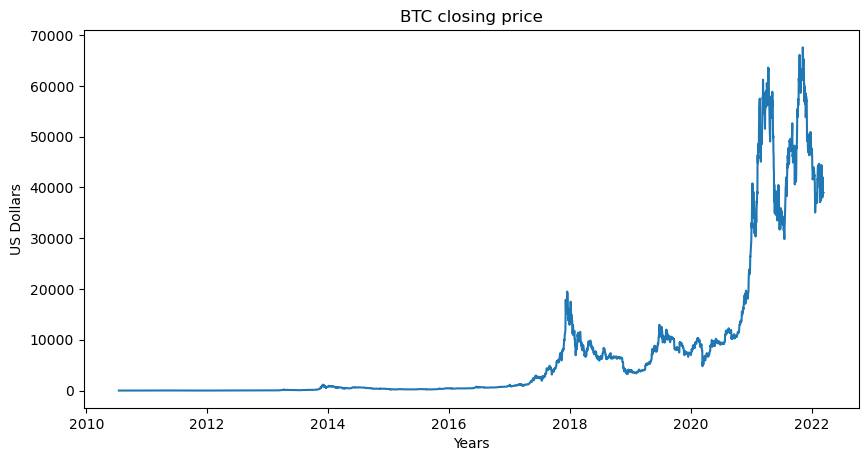

In [21]:
# plot BTC close price
plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_close)
plt.title('BTC closing price')
plt.show()

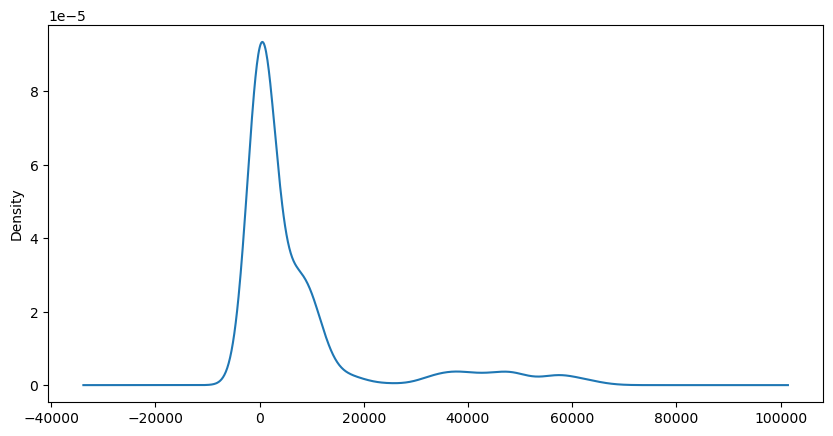

In [22]:
# data distribution
plt.figure(figsize=(10,5), dpi=100)
_ = df_close.plot(kind='kde')

ADF (Augmented Dickey-Fuller) test is used to check if series is stationary or not.

In [23]:
# test for staionarity
adf_test = adfuller(df_close)

# translation for the adf_test output
output = pd.Series(adf_test[0:4],index=['adf test','p-value','used lags','used observations'])

# unpack the last output object (dict)
for key, val in adf_test[4].items():
    output[f'critical value {key}'] =  val
print(output)

adf test                -1.152706
p-value                  0.693602
used lags               31.000000
used observations     4226.000000
critical value 1%       -3.431898
critical value 5%       -2.862224
critical value 10%      -2.567134
dtype: float64


p-value > 0.05

<Figure size 432x288 with 0 Axes>

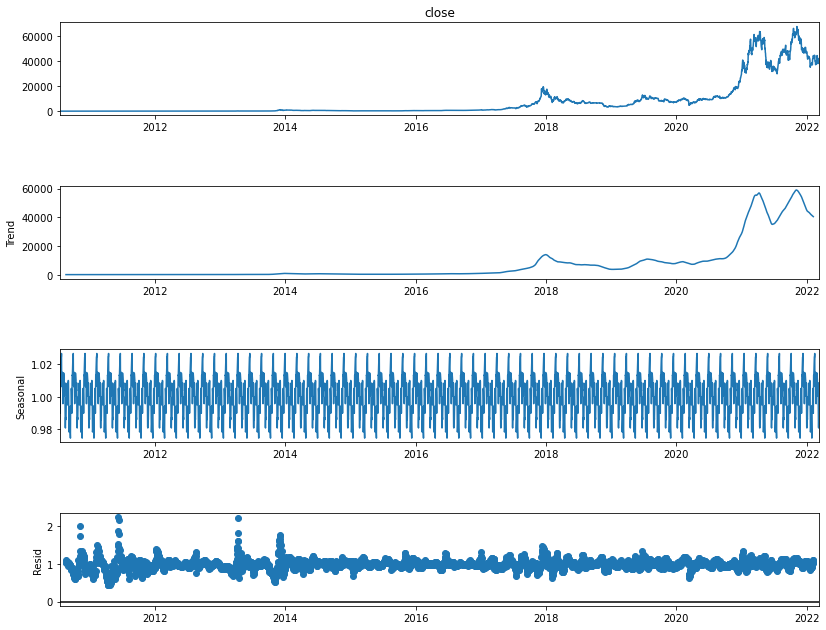

In [24]:
# checking for trend and seasonality of the data
result = seasonal_decompose(df_close, model='multiplicative', period = 66)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13, 10)

Values magnitude and the growing trend might be reduced by using logatythm on the data.
Next rolling average is calculated from data from the past year and a mean consumption value at each point of the data.

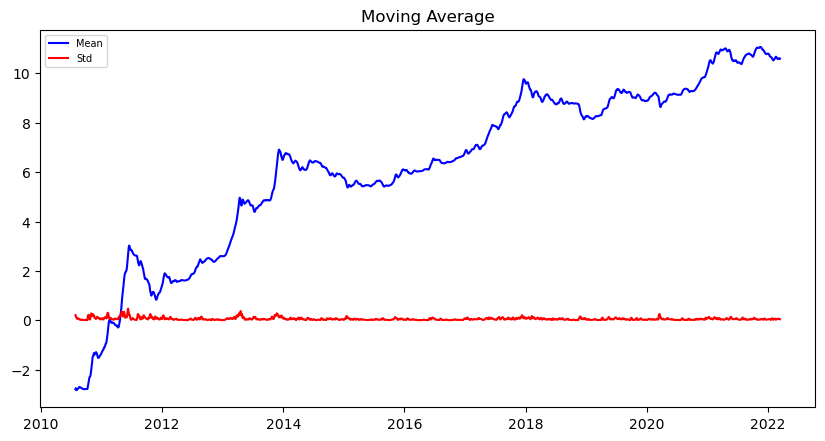

In [25]:
# if not stationary then eliminate trend
# eliminate trend

df_log = np.log(df_close)

roll_mean = df_log.rolling(12).mean()
roll_std = df_log.rolling(12).std()

plt.figure(figsize=(10,5), dpi=100)
plt.title('Moving Average')
plt.plot(roll_mean, "blue", label = "Mean")
plt.plot(roll_std, "red", label = "Std")
plt.legend(loc='upper left', fontsize=7)
plt.show()

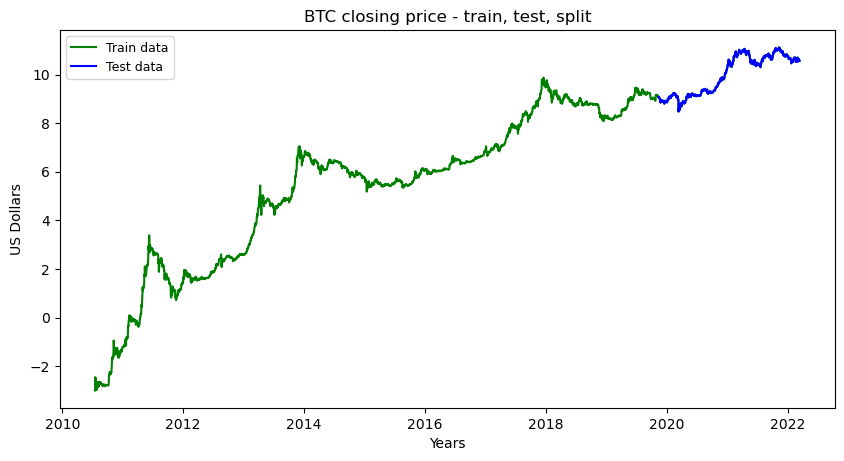

In [26]:
# train, test, split the data
# train = 0.8*data
# test  = 0.8*data

size = int(len(df_log)*0.8)

train_data, test_data = df_log[:size], df_log[size:]

plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('BTC closing price - train, test, split')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [27]:
# performing auto ARIMA model for getting optimal (p, d, q)
auto_ARIMA_model = auto_arima(train_data, start_p=0, start_q=0, 
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=5, max_q=5, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9998.544, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10000.880, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10001.164, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9986.741, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10004.027, Time=1.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10002.370, Time=1.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10002.797, Time=4.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10002.684, Time=1.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10002.240, Time=1.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10000.443, Time=4.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9993.155, Time=0.84 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 17.563 seconds


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3406
Model:               SARIMAX(1, 1, 1)   Log Likelihood                5006.013
Date:                Sun, 13 Mar 2022   AIC                         -10004.027
Time:                        16:41:00   BIC                          -9979.495
Sample:                             0   HQIC                         -9995.259
                               - 3406                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0058      0.002      3.419      0.001       0.002       0.009
ar.L1         -0.6266      0.108     -5.822      0.000      -0.838      -0.416
ma.L1          0.6685      0.104      6.398      0.0

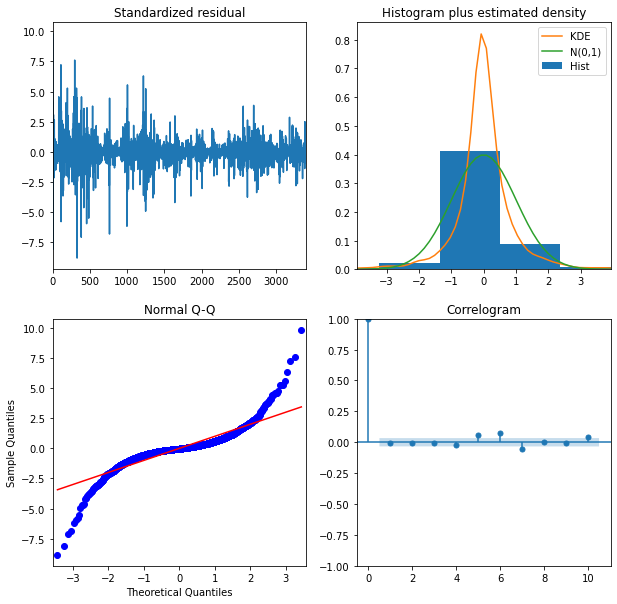

In [28]:
print(auto_ARIMA_model.summary())

auto_ARIMA_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [29]:
# Top left:     The residual errors fluctuate around a zero mean
# Top Right:    Plot suggests a normal distribution with a zero mean.
# Bottom left:  Red line should be perfectly aligned with all of the dots.
# Bottom Right: Residual errors are not autocorrelated. Correlogram, also known as the ACF plot.

Build ARIMA Model based on (p,d,q) from auto_arima

In [30]:
# ignore ARIMA warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:
model = ARIMA(train_data, order=(1,1,1))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 3405
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5006.111
Method:                       css-mle   S.D. of innovations              0.056
Date:                Sun, 13 Mar 2022   AIC                         -10004.222
Time:                        16:41:02   BIC                          -9979.690
Sample:                    07-18-2010   HQIC                         -9995.454
                         - 11-12-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0035      0.001      3.621      0.000       0.002       0.005
ar.L1.D.close    -0.5720      0.132     -4.331      0.000      -0.831      -0.313
ma.L1.D.close     0.6160      0.126     

In [32]:
# Forecast, the standard error of the forecasts, 2d array of the confidence interval for the forecast
fore_1, stderr_1, conf_1 = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

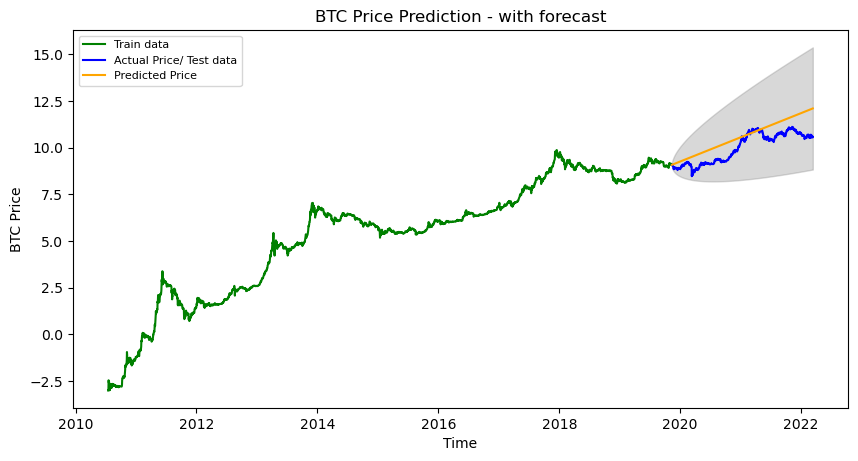

In [33]:
# convert to pandas series
fore_series = pd.Series(fore_1, index=test_data.index)
lower_conf = pd.Series(conf_1[:, 0], index=test_data.index)
upper_conf = pd.Series(conf_1[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

# add confidence area
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='grey', alpha=0.3)

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [34]:
# print performance
rmse_1 = sqrt(mean_squared_error(test_data, fore_1))
print('RMSE: %.3f' % rmse_1)

RMSE: 0.716


### 5.2. ARIMA Model  =>  complete data + without ln(data)

In [35]:
# copy full dataset
df_close = btc_df_1['close']

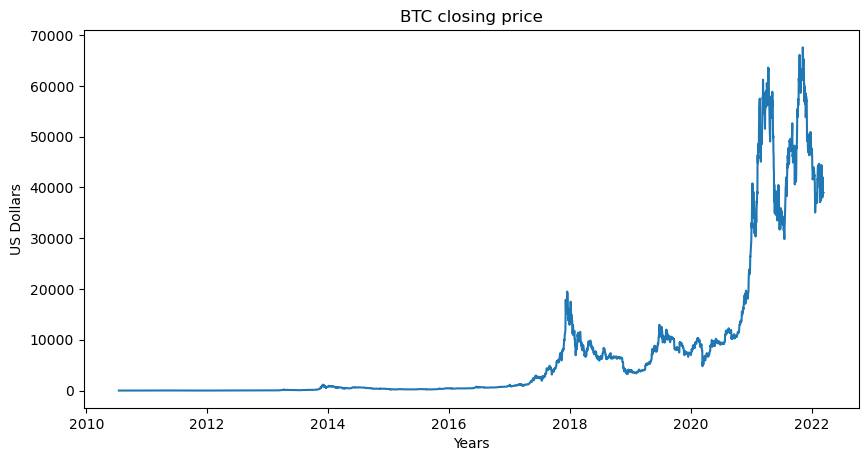

In [36]:
# plot BTC close price
plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_close)
plt.title('BTC closing price')
plt.show()

ADF (Augmented Dickey-Fuller) test is used to check if series is stationary or not.

In [37]:
# test for staionarity
adf_test = adfuller(df_close)

In [38]:
# translation for the adf_test output
output = pd.Series(adf_test[0:4],index=['adf test','p-value','used lags','used observations'])

In [39]:
# unpack the last output object (dict)
for key, val in adf_test[4].items():
    output[f'critical value {key}'] =  val
print(output)

adf test                -1.152706
p-value                  0.693602
used lags               31.000000
used observations     4226.000000
critical value 1%       -3.431898
critical value 5%       -2.862224
critical value 10%      -2.567134
dtype: float64


p-value > 0.05

<Figure size 432x288 with 0 Axes>

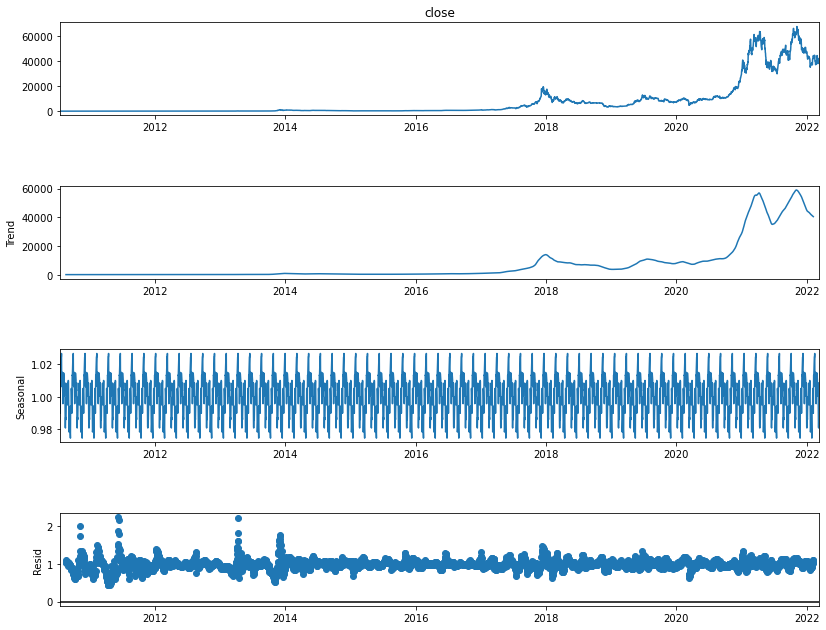

In [40]:
# checking for trend and seasonality of the data
result = seasonal_decompose(df_close, model='multiplicative', period = 66)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13, 10)

Values magnitude and the growing trend might be reduced by using logatythm on the data.
Next rolling average is calculated from data from the past year and a mean consumption value at each point of the data.

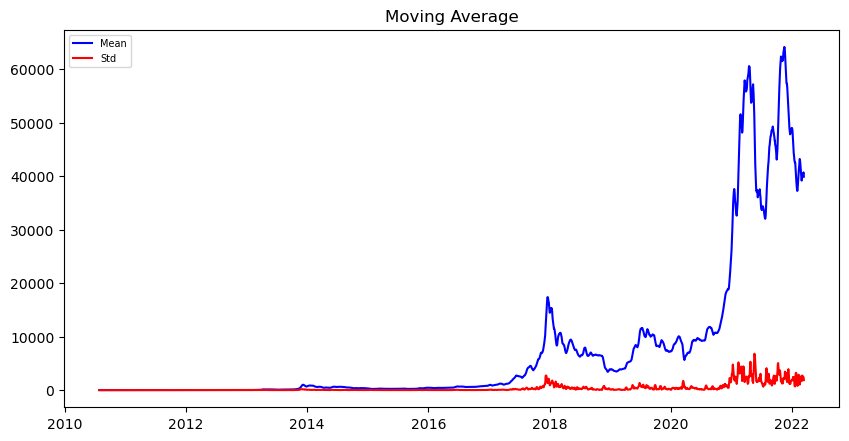

In [41]:
# if not stationary then eliminate trend
# eliminate trend

#df_log = np.log(df_close)
df_log = df_close

roll_mean = df_log.rolling(12).mean()
roll_std = df_log.rolling(12).std()

plt.figure(figsize=(10,5), dpi=100)
plt.title('Moving Average')
plt.plot(roll_mean, "blue", label = "Mean")
plt.plot(roll_std, "red", label = "Std")
plt.legend(loc='upper left', fontsize=7)
plt.show()

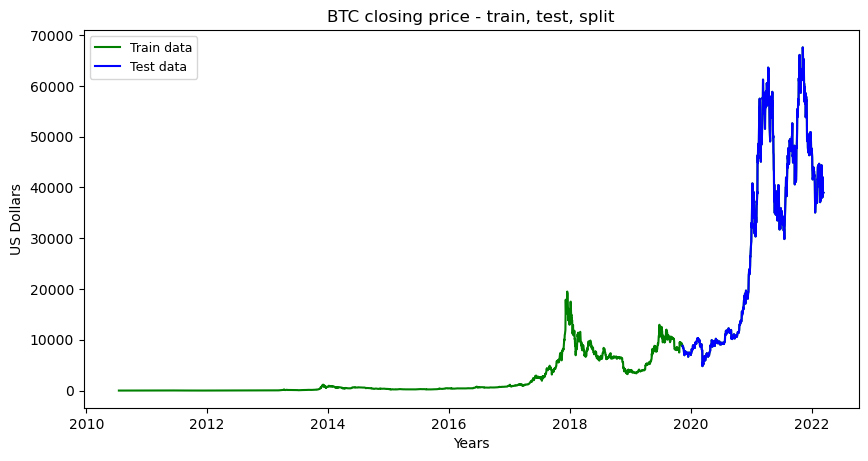

In [42]:
# train, test, split the data
# train = 0.8*data
# test  = 0.8*data

size = int(len(df_log)*0.8)

train_data, test_data = df_log[:size], df_log[size:]

plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('BTC closing price - train, test, split')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [43]:
# performing auto ARIMA model for getting optimal (p, d, q)
auto_ARIMA_model = auto_arima(train_data, start_p=0, start_q=0, 
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=5, max_q=5, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46063.050, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46059.857, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46059.503, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46061.568, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46043.870, Time=1.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=46044.689, Time=2.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=46044.824, Time=1.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=46057.546, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46058.227, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=46047.074, Time=3.60 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=46042.297, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=46057.981, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46058.336, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=46043.190, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3406
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -22988.124
Date:                Sun, 13 Mar 2022   AIC                          45986.248
Time:                        16:41:32   BIC                          46016.913
Sample:                             0   HQIC                         45997.207
                               - 3406                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7626      0.006   -279.679      0.000      -1.775      -1.750
ar.L2         -0.9154      0.006   -152.745      0.000      -0.927      -0.904
ma.L1          1.8212      0.006    326.488      0.0

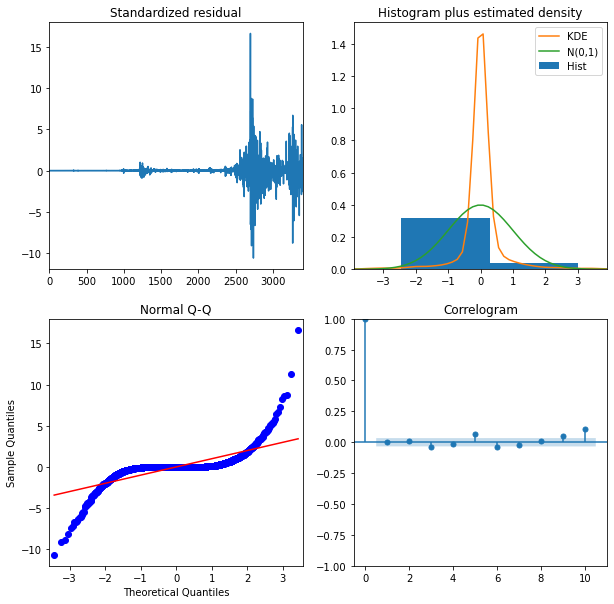

In [44]:
print(auto_ARIMA_model.summary())

auto_ARIMA_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [45]:
# Top left:     The residual errors fluctuate around a zero mean
# Top Right:    Plot suggests a normal distribution with a zero mean.
# Bottom left:  Red line should be perfectly aligned with all of the dots.
# Bottom Right: Residual errors are not autocorrelated. Correlogram, also known as the ACF plot.

Build ARIMA Model based on (p,d,q) from auto_arima

In [46]:
# ignore ARIMA warnings
warnings.filterwarnings('ignore')

In [47]:
model = ARIMA(train_data, order=(2,1,2))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 3405
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -22987.682
Method:                       css-mle   S.D. of innovations            206.881
Date:                Sun, 13 Mar 2022   AIC                          45987.363
Time:                        16:41:36   BIC                          46024.161
Sample:                    07-18-2010   HQIC                         46000.514
                         - 11-12-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5963      3.639      0.713      0.476      -4.537       9.729
ar.L1.D.close    -1.7636      0.019    -90.557      0.000      -1.802      -1.725
ar.L2.D.close    -0.9167      0.017    -

In [48]:
# Forecast, the standard error of the forecasts, 2d array of the confidence interval for the forecast
fore_2, stderr_2, conf_2 = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

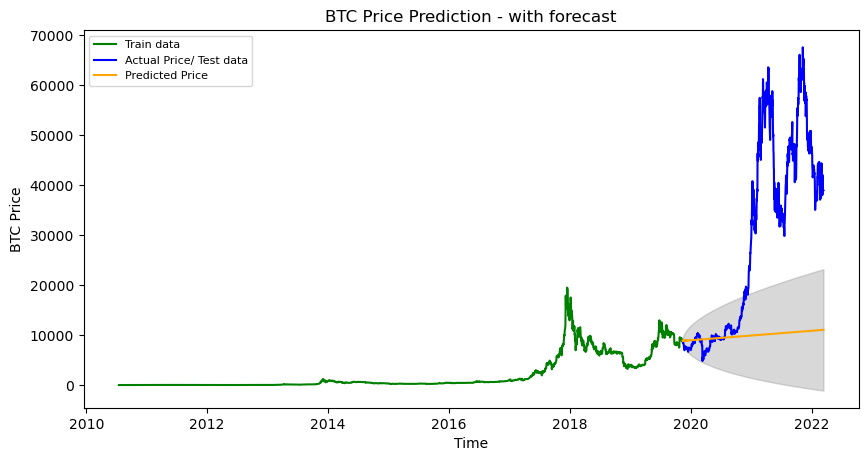

In [49]:
# convert to pandas series
fore_series = pd.Series(fore_2, index=test_data.index)
lower_conf = pd.Series(conf_2[:, 0], index=test_data.index)
upper_conf = pd.Series(conf_2[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

# add confidence area
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='grey', alpha=0.3)

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [50]:
# print performance
rmse_2 = sqrt(mean_squared_error(test_data, fore_2))
print('RMSE: %.3f' % rmse_2)

RMSE: 26752.347


### 5.3. ARIMA Model  =>  data start from 2018-01-01 + ln(data)

In [51]:
# copy data starting from 2018-01-01
df_close = btc_df_1['close'].iloc[2725:]

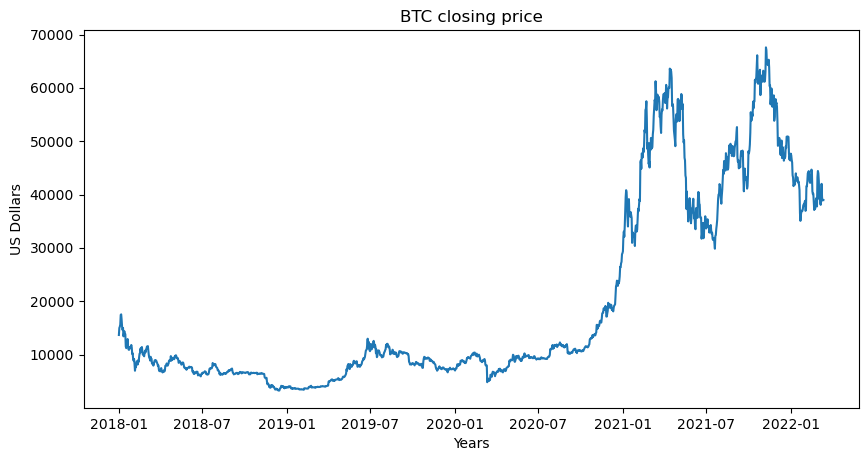

In [52]:
# plot BTC close price
plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_close)
plt.title('BTC closing price')
plt.show()

ADF (Augmented Dickey-Fuller) test is used to check if series is stationary or not.

In [53]:
# test for staionarity
adf_test = adfuller(df_close)

In [54]:
# translation for the adf_test output
output = pd.Series(adf_test[0:4],index=['adf test','p-value','used lags','used observations'])

In [55]:
# unpack the last output object (dict)
for key, val in adf_test[4].items():
    output[f'critical value {key}'] =  val
print(output)

adf test                -0.972469
p-value                  0.763173
used lags               24.000000
used observations     1508.000000
critical value 1%       -3.434694
critical value 5%       -2.863459
critical value 10%      -2.567791
dtype: float64


p-value > 0.05

<Figure size 432x288 with 0 Axes>

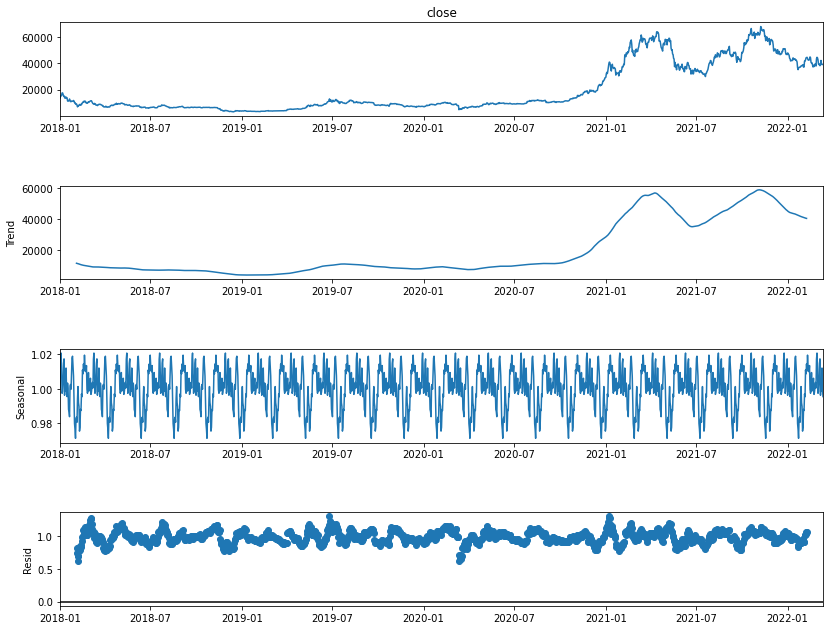

In [56]:
# checking for trend and seasonality of the data
result = seasonal_decompose(df_close, model='multiplicative', period = 66)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13, 10)

Values magnitude and the growing trend might be reduced by using logatythm on the data.
Next rolling average is calculated from data from the past year and a mean consumption value at each point of the data.

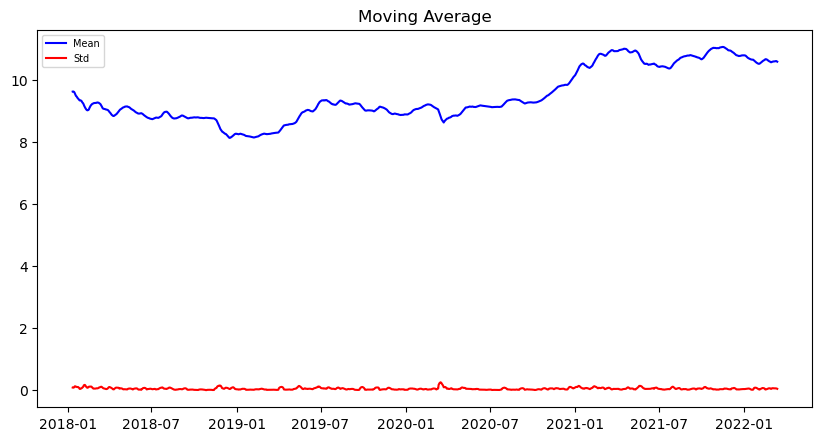

In [57]:
# if not stationary then eliminate trend
# eliminate trend

df_log = np.log(df_close)

roll_mean = df_log.rolling(12).mean()
roll_std = df_log.rolling(12).std()

plt.figure(figsize=(10,5), dpi=100)
plt.title('Moving Average')
plt.plot(roll_mean, "blue", label = "Mean")
plt.plot(roll_std, "red", label = "Std")
plt.legend(loc='upper left', fontsize=7)
plt.show()

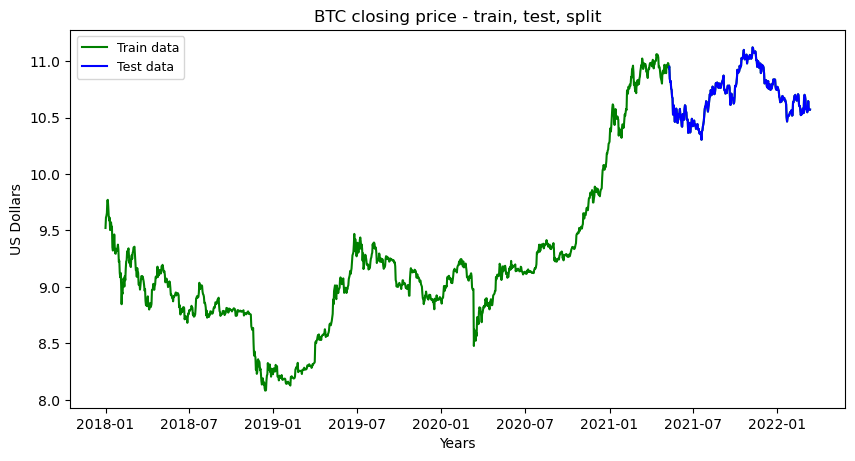

In [58]:
# train, test, split the data
# train = 0.8*data
# test  = 0.8*data

size = int(len(df_log)*0.8)

train_data, test_data = df_log[:size], df_log[size:]

plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('BTC closing price - train, test, split')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [59]:
# performing auto ARIMA model for getting optimal (p, d, q)
auto_ARIMA_model = auto_arima(train_data, start_p=0, start_q=0, 
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=5, max_q=5, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4351.374, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4355.580, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4354.976, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4352.402, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4356.686, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4355.023, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4355.530, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4355.758, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4353.071, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4357.675, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4356.465, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4356.041, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4356.625, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4356.679, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1226
Model:               SARIMAX(2, 1, 0)   Log Likelihood                2181.837
Date:                Sun, 13 Mar 2022   AIC                          -4357.675
Time:                        16:41:45   BIC                          -4342.343
Sample:                             0   HQIC                         -4351.905
                               - 1226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0675      0.020     -3.381      0.001      -0.107      -0.028
ar.L2          0.0511      0.027      1.869      0.062      -0.002       0.105
sigma2         0.0017      2e-05     83.079      0.0

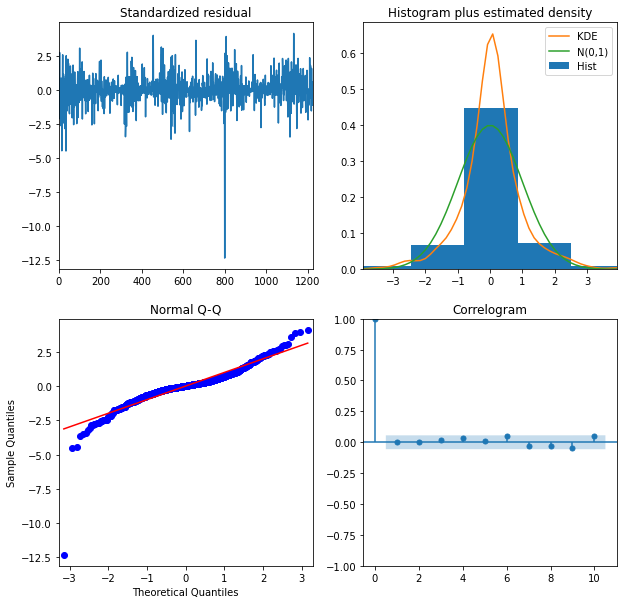

In [60]:
print(auto_ARIMA_model.summary())

auto_ARIMA_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [61]:
# Top left:     The residual errors fluctuate around a zero mean
# Top Right:    Plot suggests a normal distribution with a zero mean.
# Bottom left:  Red line should be perfectly aligned with all of the dots.
# Bottom Right: Residual errors are not autocorrelated. Correlogram, also known as the ACF plot.

Build ARIMA Model based on (p,d,q) from auto_arima

In [62]:
# ignore ARIMA warnings
warnings.filterwarnings('ignore')

In [63]:
model = ARIMA(train_data, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2182.343
Method:                       css-mle   S.D. of innovations              0.041
Date:                Sun, 13 Mar 2022   AIC                          -4356.686
Time:                        16:41:47   BIC                          -4336.243
Sample:                    01-02-2018   HQIC                         -4348.993
                         - 05-10-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.006      0.314      -0.001       0.003
ar.L1.D.close    -0.0676      0.029     -2.364      0.018      -0.124      -0.012
ar.L2.D.close     0.0504      0.029     

In [64]:
# Forecast, the standard error of the forecasts, 2d array of the confidence interval for the forecast
fore_3, stderr_3, conf_3 = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

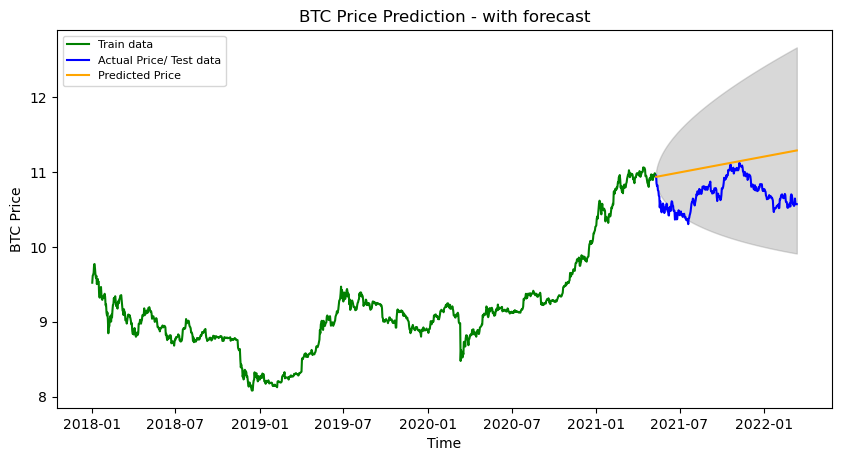

In [65]:
# convert to pandas series
fore_series = pd.Series(fore_3, index=test_data.index)
lower_conf = pd.Series(conf_3[:, 0], index=test_data.index)
upper_conf = pd.Series(conf_3[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

# add confidence area
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='grey', alpha=0.3)

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [66]:
# print performance
rmse_3 = sqrt(mean_squared_error(test_data, fore_3))
print('RMSE: %.3f' % rmse_3)

RMSE: 0.452


### 5.4. ARIMA Model  =>  data start from 2021-01-01 + ln(data)

In [67]:
# copy data starting from 2021-01-01
df_close = btc_df_1['close'].iloc[3821:]

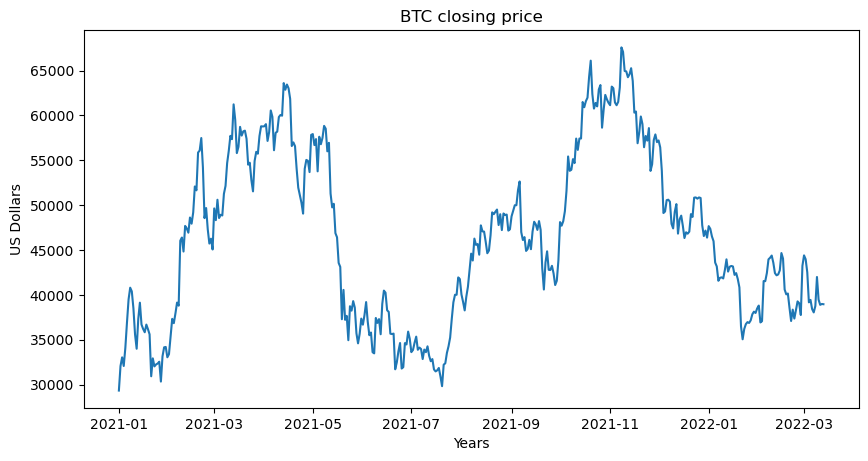

In [68]:
# plot BTC close price
plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_close)
plt.title('BTC closing price')
plt.show()

ADF (Augmented Dickey-Fuller) test is used to check if series is stationary or not.

In [69]:
# test for staionarity
adf_test = adfuller(df_close)

In [70]:
# translation for the adf_test output
output = pd.Series(adf_test[0:4],index=['adf test','p-value','used lags','used observations'])

In [71]:
# unpack the last output object (dict)
for key, val in adf_test[4].items():
    output[f'critical value {key}'] =  val
print(output)

adf test               -2.387191
p-value                 0.145384
used lags               0.000000
used observations     436.000000
critical value 1%      -3.445438
critical value 5%      -2.868192
critical value 10%     -2.570313
dtype: float64


p-value > 0.05

<Figure size 432x288 with 0 Axes>

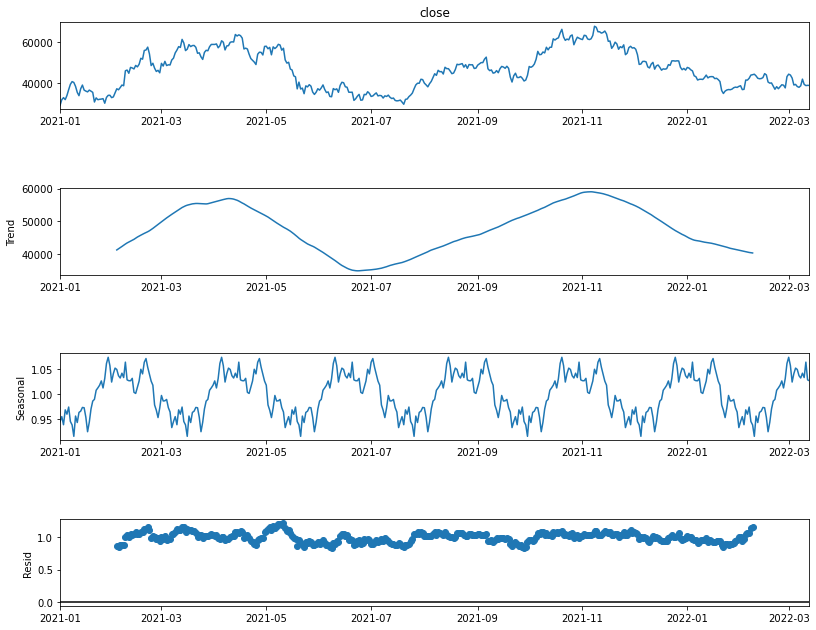

In [72]:
# checking for trend and seasonality of the data
result = seasonal_decompose(df_close, model='multiplicative', period = 66)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13, 10)

Values magnitude and the growing trend might be reduced by using logatythm on the data.
Next rolling average is calculated from data from the past year and a mean consumption value at each point of the data.

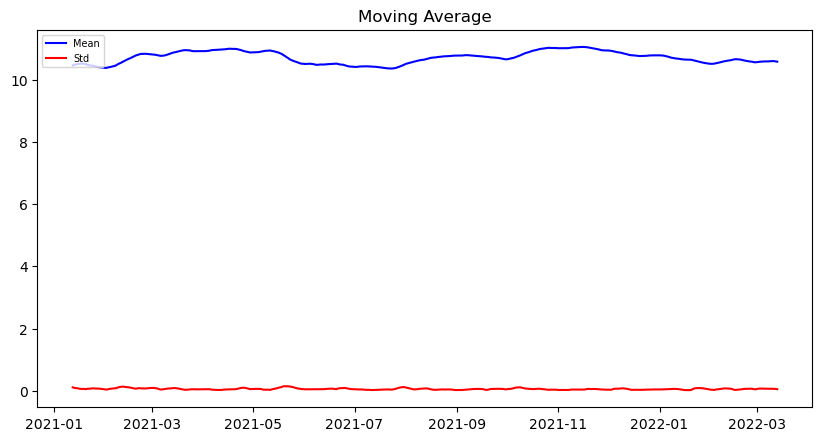

In [73]:
# if not stationary then eliminate trend
# eliminate trend

df_log = np.log(df_close)

roll_mean = df_log.rolling(12).mean()
roll_std = df_log.rolling(12).std()

plt.figure(figsize=(10,5), dpi=100)
plt.title('Moving Average')
plt.plot(roll_mean, "blue", label = "Mean")
plt.plot(roll_std, "red", label = "Std")
plt.legend(loc='upper left', fontsize=7)
plt.show()

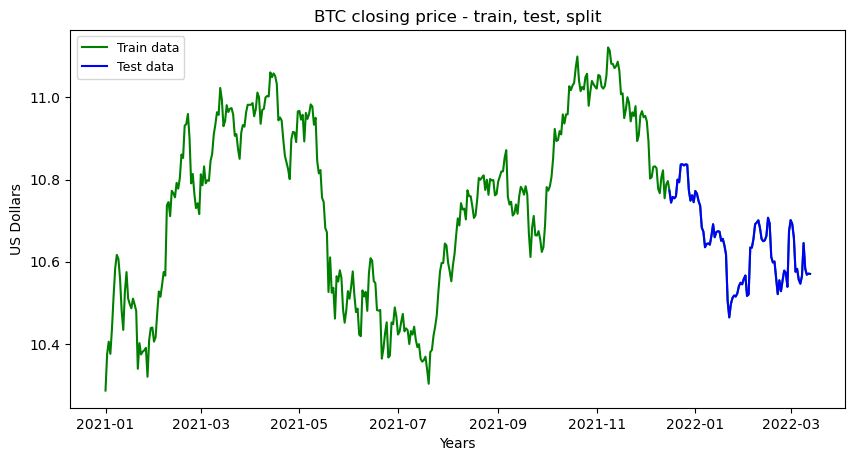

In [74]:
# train, test, split the data
# train = 0.8*data
# test  = 0.8*data

size = int(len(df_log)*0.8)

train_data, test_data = df_log[:size], df_log[size:]

plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('BTC closing price - train, test, split')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [75]:
# performing auto ARIMA model for getting optimal (p, d, q)
auto_ARIMA_model = auto_arima(train_data, start_p=0, start_q=0, 
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=5, max_q=5, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1210.095, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1208.820, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1208.833, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1211.678, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1206.848, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.741 seconds


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  349
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 606.839
Date:                Sun, 13 Mar 2022   AIC                          -1211.678
Time:                        16:41:51   BIC                          -1207.826
Sample:                             0   HQIC                         -1210.144
                                - 349                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0018      0.000     16.641      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                21.61
Prob(Q):                              0.40   Pr

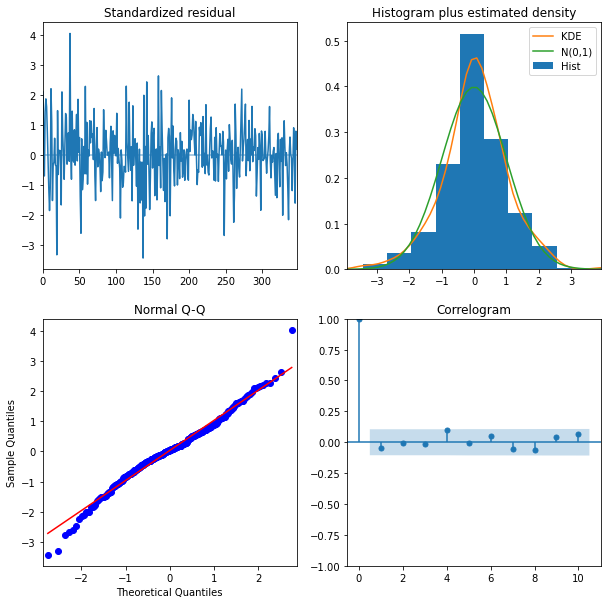

In [76]:
print(auto_ARIMA_model.summary())

auto_ARIMA_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [77]:
# Top left:     The residual errors fluctuate around a zero mean
# Top Right:    Plot suggests a normal distribution with a zero mean.
# Bottom left:  Red line should be perfectly aligned with all of the dots.
# Bottom Right: Residual errors are not autocorrelated. Correlogram, also known as the ACF plot.

Build ARIMA Model based on (p,d,q) from auto_arima

In [78]:
# ignore ARIMA warnings
warnings.filterwarnings('ignore')

In [79]:
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  348
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 607.047
Method:                           css   S.D. of innovations              0.042
Date:                Sun, 13 Mar 2022   AIC                          -1210.095
Time:                        16:41:52   BIC                          -1202.391
Sample:                    01-02-2021   HQIC                         -1207.028
                         - 12-15-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.646      0.518      -0.003       0.006


In [80]:
# Forecast, the standard error of the forecasts, 2d array of the confidence interval for the forecast
fore_4, stderr_4, conf_4 = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

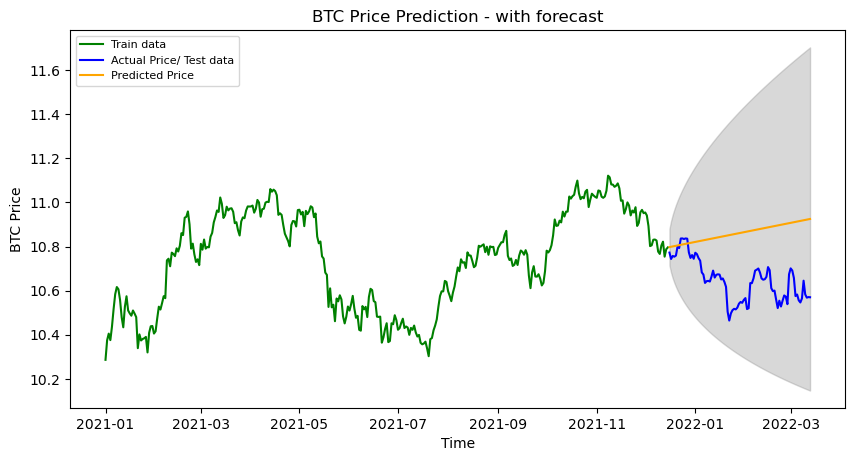

In [81]:
# convert to pandas series
fore_series = pd.Series(fore_4, index=test_data.index)
lower_conf = pd.Series(conf_4[:, 0], index=test_data.index)
upper_conf = pd.Series(conf_4[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

# add confidence area
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='grey', alpha=0.3)

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [82]:
# print performance
rmse_4 = sqrt(mean_squared_error(test_data, fore_4))
print('RMSE: %.3f' % rmse_4)

RMSE: 0.246


### 5.5. ARIMA Model  =>  summary

Prediction of Bitcoin Price based on historical data was performed with ARIMA model in addition to auto_arima for getting optimal (p, d, q).

- In first try complete dataset has been used and stationarity of the time series has been achaived by using natural logarythm on the data set.

- Second try was also on comlete data set but without natural logarythm on the data. In this case prediction of BTC price was with very high Root Mean Square Error (RMSE).

- Third try was with sliced data started from 2018-01-01 and with using natural logarythm on the data set.

- Fourth try was with sliced data started from 2021-01-01 and with using natural logarythm on the data set. This case gave the lowest RMSE.

In concluzion - by using ARIMA model on Bitcoin historical data, the series data shoud be stacjonary and the most recend data gives the best (short term) predictions.

Too high RMSE_2: 26752.347


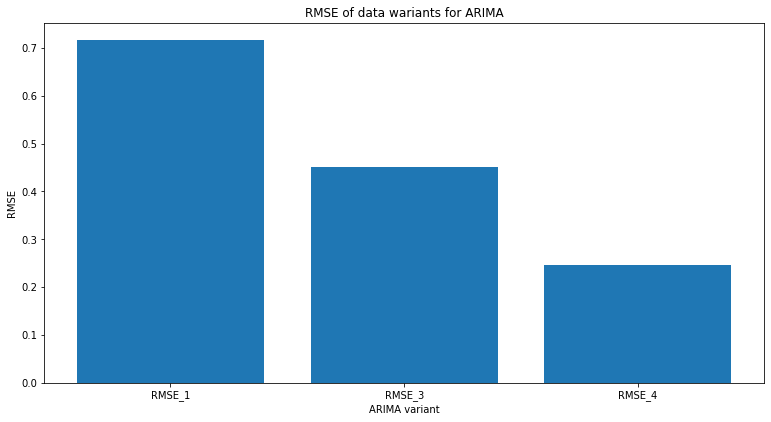

In [83]:
# plot for the RMSE's of data wariants for ARIMA

print('Too high RMSE_2: %.3f' % rmse_2)


ARIMA_variant = ['RMSE_1', 'RMSE_3', 'RMSE_4']
variables = [rmse_1, rmse_3, rmse_4]

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ARIMA_variant, variables)

plt.xlabel('ARIMA variant')
plt.ylabel('RMSE')
plt.title('RMSE of data wariants for ARIMA')
plt.show()